# Imports

In [337]:
import os
import re
import itertools

# pandas
import pandas as pd, numpy as np
from pandas import DataFrame

# tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

# cross-validation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from __future__ import print_function
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix

# ML classifiers
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.dummy import DummyClassifier

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.sparse import hstack

# Read data

In [327]:
DATA_PATH = '/Users/cep215/Desktop/book-reviews/jupyter/exports/'

def read_data(data_path = DATA_PATH):
    data_path = os.path.join(data_path, 'parent-child.csv')
    df = pd.read_csv(data_path)
    return df
data = read_data()
pairs_df = pd.DataFrame(data)
data.loc[pairs_df["Relationship"]==True,"Relationship",]=1
data.loc[pairs_df["Relationship"]==False,"Relationship",]=0

# Summary

In [328]:
data.describe().transpose()

count      mean       std  min  25%  50%  75%  max
Level         487.0  2.412731  0.829052  2.0  2.0  2.0  3.0  8.0
Relationship  487.0  0.439425  0.496827  0.0  0.0  0.0  1.0  1.0
Supports      487.0  0.063655  0.387635  0.0  0.0  0.0  0.0  4.0
Attacks       487.0  0.004107  0.090629  0.0  0.0  0.0  0.0  2.0
Neutrals      487.0  0.002053  0.045314  0.0  0.0  0.0  0.0  1.0

# Data (DF_X) & Label(DF_Y)

In [329]:
pairs = []
sent_diff = []
for index, row in pairs_df.iterrows():
    pair = row["Parent"] + " STOP " + row["Post"]
    pairs.append(pair)
    analyzer = SentimentIntensityAnalyzer()
    sent_child = analyzer.polarity_scores(row["Parent"])['compound']
    sent_parent = analyzer.polarity_scores(row["Post"])['compound']
    if (sent_child < sent_parent):
        sent_diff.append(sent_parent - sent_child)
    else:
        sent_diff.append(sent_child - sent_parent)
df_x = pd.DataFrame(pairs)[0]
df_y=pairs_df["Relationship"]
sent_diff = pd.DataFrame(sent_diff)

# Add TF-IFD feature

In [330]:
tfidf = TfidfVectorizer(min_df=1)
df_x = tfidf.fit_transform(df_x)

# Add Sentiment Feature

In [331]:
df_x = hstack((df_x , np.array(sent_diff[0])[:,None]))
df_x = df_x.tocsr()

# Cross-Validation

In [332]:
skf = StratifiedKFold(n_splits=8)

# Dummy Classification

In [341]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

acc = 0
f1 = 0
for train_index, test_index in skf.split(df_x, df_y):
    x_train, x_test = df_x[train_index], df_x[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]
    clf = DummyClassifier()
    clf.fit(x_train, y_train) 
    prediction = clf.predict(x_test)
    print(classification_report(y_test, prediction))
    f1 += f1_score(y_test, prediction, average='weighted')
    acc += accuracy_score(y_test, prediction)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, prediction)
    np.set_printoptions(precision=2)
    
    # Plot normalized confusion matrix
#     plt.figure()
#     plot_confusion_matrix(cnf_matrix, classes=["attack", "support"], normalize=True,
#                           title='Normalized confusion matrix')

#     plt.show()

print (acc/8)
print(f1/8)

average_precision = average_precision_score(y_test, prediction)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

# precision, recall, _ = precision_recall_curve(y_test, prediction)

# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2,
#                  color='b')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#           average_precision))
    

             precision    recall  f1-score   support

          0       0.54      0.60      0.57        35
          1       0.39      0.33      0.36        27

avg / total       0.47      0.48      0.48        62

             precision    recall  f1-score   support

          0       0.58      0.56      0.57        34
          1       0.46      0.48      0.47        27

avg / total       0.53      0.52      0.53        61

             precision    recall  f1-score   support

          0       0.58      0.56      0.57        34
          1       0.46      0.48      0.47        27

avg / total       0.53      0.52      0.53        61

             precision    recall  f1-score   support

          0       0.61      0.68      0.64        34
          1       0.52      0.44      0.48        27

avg / total       0.57      0.57      0.57        61

             precision    recall  f1-score   support

          0       0.55      0.47      0.51        34
          1       0.44      0.52 

# Decision Tree

             precision    recall  f1-score   support

          0       0.66      0.66      0.66        35
          1       0.56      0.56      0.56        27

avg / total       0.61      0.61      0.61        62

Normalized confusion matrix
[[0.66 0.34]
 [0.44 0.56]]


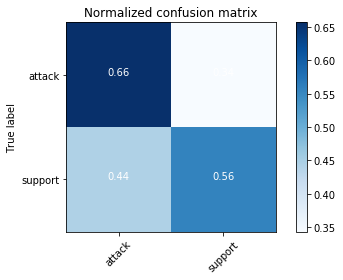

             precision    recall  f1-score   support

          0       0.59      0.76      0.67        34
          1       0.53      0.33      0.41        27

avg / total       0.56      0.57      0.55        61

Normalized confusion matrix
[[0.76 0.24]
 [0.67 0.33]]


             precision    recall  f1-score   support

          0       0.61      0.50      0.55        34
          1       0.48      0.59      0.53        27

avg / total       0.55      0.54      0.54        61

Normalized confusion matrix
[[0.5  0.5 ]
 [0.41 0.59]]


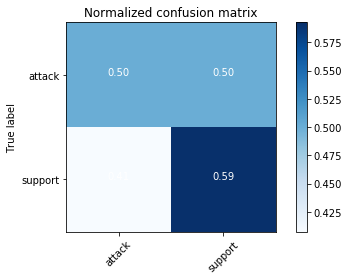

             precision    recall  f1-score   support

          0       0.61      0.68      0.64        34
          1       0.52      0.44      0.48        27

avg / total       0.57      0.57      0.57        61

Normalized confusion matrix
[[0.68 0.32]
 [0.56 0.44]]


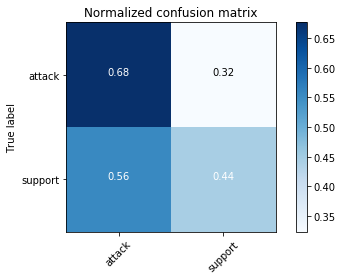

             precision    recall  f1-score   support

          0       0.67      0.65      0.66        34
          1       0.57      0.59      0.58        27

avg / total       0.62      0.62      0.62        61

Normalized confusion matrix
[[0.65 0.35]
 [0.41 0.59]]


             precision    recall  f1-score   support

          0       0.64      0.74      0.68        34
          1       0.59      0.48      0.53        27

avg / total       0.62      0.62      0.62        61

Normalized confusion matrix
[[0.74 0.26]
 [0.52 0.48]]


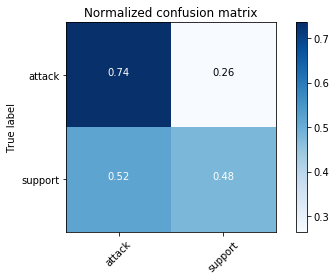

             precision    recall  f1-score   support

          0       0.71      0.65      0.68        34
          1       0.59      0.65      0.62        26

avg / total       0.66      0.65      0.65        60

Normalized confusion matrix
[[0.65 0.35]
 [0.35 0.65]]


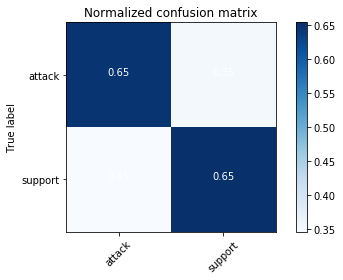

             precision    recall  f1-score   support

          0       0.68      0.74      0.70        34
          1       0.61      0.54      0.57        26

avg / total       0.65      0.65      0.65        60

Normalized confusion matrix
[[0.74 0.26]
 [0.46 0.54]]


0.6059161819143312
0.6017731921948042
Average precision-recall score: 0.53


Text(0.5,1,'2-class Precision-Recall curve: AP=0.53')

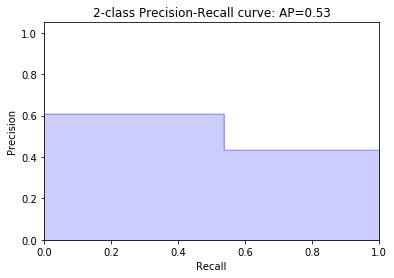

In [333]:



acc = 0
f1 = 0
for train_index, test_index in skf.split(df_x, df_y):
    x_train, x_test = df_x[train_index], df_x[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]
    clf = DecisionTreeClassifier()
    clf.fit(x_train, y_train) 
    prediction = clf.predict(x_test)
    print(classification_report(y_test, prediction))
    f1 += f1_score(y_test, prediction, average='weighted')
    acc += accuracy_score(y_test, prediction)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, prediction)
    np.set_printoptions(precision=2)
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["attack", "support"], normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

print (acc/8)
print(f1/8)

average_precision = average_precision_score(y_test, prediction)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, prediction)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
    

# Random Forest

             precision    recall  f1-score   support

          0       0.61      0.77      0.68        35
          1       0.56      0.37      0.44        27

avg / total       0.59      0.60      0.58        62

Normalized confusion matrix
[[0.77 0.23]
 [0.63 0.37]]


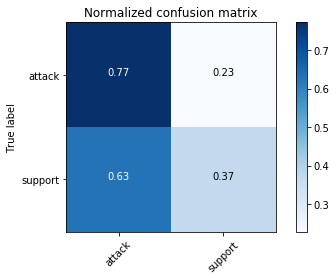

             precision    recall  f1-score   support

          0       0.59      0.76      0.67        34
          1       0.53      0.33      0.41        27

avg / total       0.56      0.57      0.55        61

Normalized confusion matrix
[[0.76 0.24]
 [0.67 0.33]]


             precision    recall  f1-score   support

          0       0.57      0.74      0.64        34
          1       0.47      0.30      0.36        27

avg / total       0.52      0.54      0.52        61

Normalized confusion matrix
[[0.74 0.26]
 [0.7  0.3 ]]


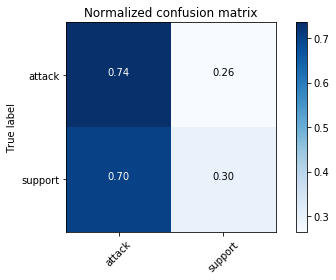

             precision    recall  f1-score   support

          0       0.55      0.88      0.67        34
          1       0.33      0.07      0.12        27

avg / total       0.45      0.52      0.43        61

Normalized confusion matrix
[[0.88 0.12]
 [0.93 0.07]]


             precision    recall  f1-score   support

          0       0.47      0.53      0.50        34
          1       0.30      0.26      0.28        27

avg / total       0.40      0.41      0.40        61

Normalized confusion matrix
[[0.53 0.47]
 [0.74 0.26]]


             precision    recall  f1-score   support

          0       0.57      0.76      0.65        34
          1       0.47      0.26      0.33        27

avg / total       0.52      0.54      0.51        61

Normalized confusion matrix
[[0.76 0.24]
 [0.74 0.26]]


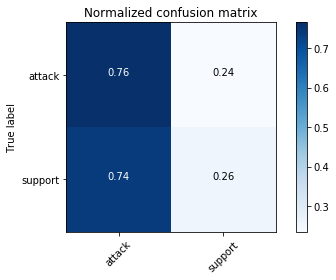

             precision    recall  f1-score   support

          0       0.63      0.97      0.77        34
          1       0.88      0.27      0.41        26

avg / total       0.74      0.67      0.61        60

Normalized confusion matrix
[[0.97 0.03]
 [0.73 0.27]]


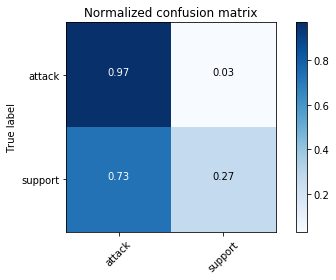

             precision    recall  f1-score   support

          0       0.60      0.76      0.68        34
          1       0.53      0.35      0.42        26

avg / total       0.57      0.58      0.56        60

Normalized confusion matrix
[[0.76 0.24]
 [0.65 0.35]]


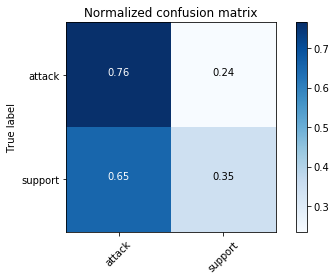

0.554617265996827
0.5211986491781737
Average precision-recall score: 0.47


Text(0.5,1,'2-class Precision-Recall curve: AP=0.47')

In [334]:
acc = 0
f1 = 0
for train_index, test_index in skf.split(df_x, df_y):
    x_train, x_test = df_x[train_index], df_x[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]
    clf = RandomForestClassifier()
    clf.fit(x_train, y_train) 
    prediction = clf.predict(x_test)
    print(classification_report(y_test, prediction))
    f1 += f1_score(y_test, prediction, average='weighted')
    acc += accuracy_score(y_test, prediction)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, prediction)
    np.set_printoptions(precision=2)
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["attack", "support"], normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    
print (acc/8)
print(f1/8)

average_precision = average_precision_score(y_test, prediction)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, prediction)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
    

# LinearSVC

             precision    recall  f1-score   support

          0       0.63      0.77      0.69        35
          1       0.58      0.41      0.48        27

avg / total       0.61      0.61      0.60        62

Normalized confusion matrix
[[0.77 0.23]
 [0.59 0.41]]


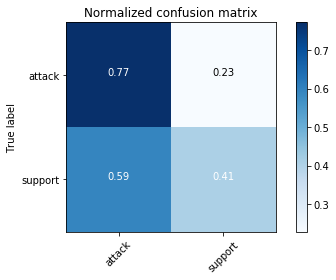

             precision    recall  f1-score   support

          0       0.60      0.76      0.68        34
          1       0.56      0.37      0.44        27

avg / total       0.58      0.59      0.57        61

Normalized confusion matrix
[[0.76 0.24]
 [0.63 0.37]]


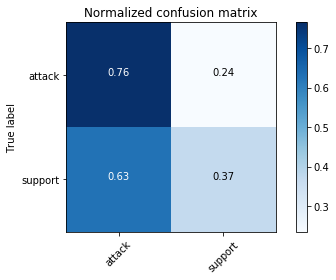

             precision    recall  f1-score   support

          0       0.54      0.56      0.55        34
          1       0.42      0.41      0.42        27

avg / total       0.49      0.49      0.49        61

Normalized confusion matrix
[[0.56 0.44]
 [0.59 0.41]]


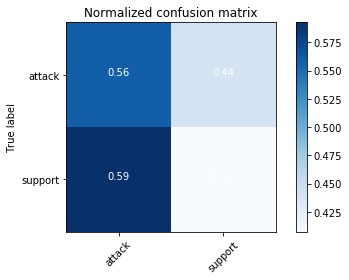

             precision    recall  f1-score   support

          0       0.50      0.59      0.54        34
          1       0.33      0.26      0.29        27

avg / total       0.43      0.44      0.43        61

Normalized confusion matrix
[[0.59 0.41]
 [0.74 0.26]]


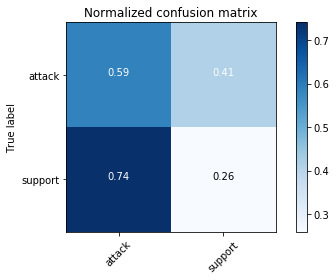

             precision    recall  f1-score   support

          0       0.50      0.38      0.43        34
          1       0.40      0.52      0.45        27

avg / total       0.46      0.44      0.44        61

Normalized confusion matrix
[[0.38 0.62]
 [0.48 0.52]]


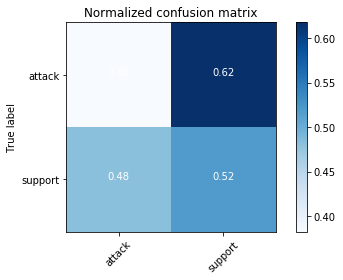

             precision    recall  f1-score   support

          0       0.68      0.62      0.65        34
          1       0.57      0.63      0.60        27

avg / total       0.63      0.62      0.62        61

Normalized confusion matrix
[[0.62 0.38]
 [0.37 0.63]]


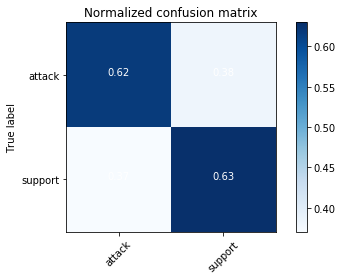

             precision    recall  f1-score   support

          0       0.70      0.76      0.73        34
          1       0.65      0.58      0.61        26

avg / total       0.68      0.68      0.68        60

Normalized confusion matrix
[[0.76 0.24]
 [0.42 0.58]]


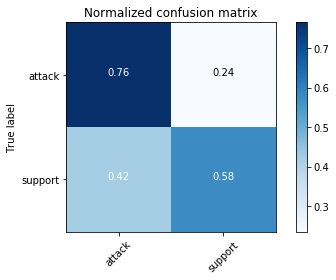

             precision    recall  f1-score   support

          0       0.68      0.76      0.72        34
          1       0.64      0.54      0.58        26

avg / total       0.66      0.67      0.66        60

Normalized confusion matrix
[[0.76 0.24]
 [0.46 0.54]]


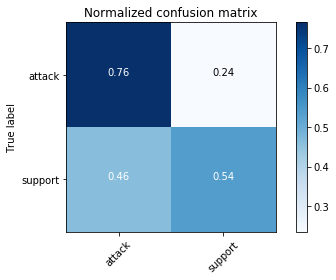

0.5691333950290852
0.5626579128015
Average precision-recall score: 0.54


Text(0.5,1,'2-class Precision-Recall curve: AP=0.54')

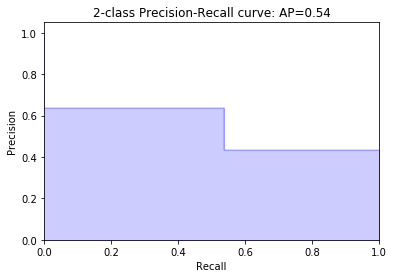

In [335]:
acc = 0
f1 = 0
for train_index, test_index in skf.split(df_x, df_y):
    x_train, x_test = df_x[train_index], df_x[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]
    clf = LinearSVC()
    clf.fit(x_train, y_train) 
    prediction = clf.predict(x_test)
    print(classification_report(y_test, prediction))
    f1 += f1_score(y_test, prediction, average='weighted')
    acc += accuracy_score(y_test, prediction)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, prediction)
    np.set_printoptions(precision=2)
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["attack", "support"], normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    
print (acc/8)
print(f1/8)

average_precision = average_precision_score(y_test, prediction)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, prediction)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
    

# NuSVC

             precision    recall  f1-score   support

          0       0.62      0.60      0.61        35
          1       0.50      0.52      0.51        27

avg / total       0.57      0.56      0.57        62

Normalized confusion matrix
[[0.6  0.4 ]
 [0.48 0.52]]


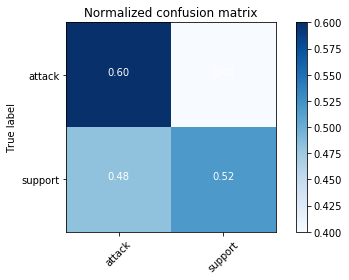

             precision    recall  f1-score   support

          0       0.62      0.76      0.68        34
          1       0.58      0.41      0.48        27

avg / total       0.60      0.61      0.59        61

Normalized confusion matrix
[[0.76 0.24]
 [0.59 0.41]]


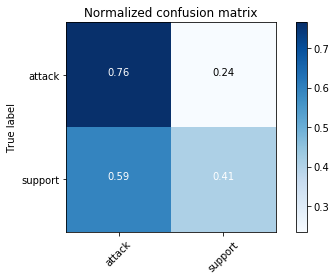

             precision    recall  f1-score   support

          0       0.55      0.53      0.54        34
          1       0.43      0.44      0.44        27

avg / total       0.49      0.49      0.49        61

Normalized confusion matrix
[[0.53 0.47]
 [0.56 0.44]]


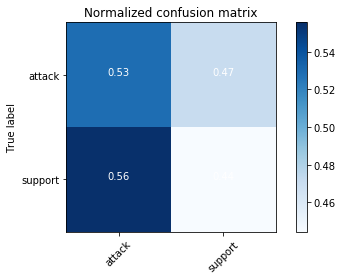

             precision    recall  f1-score   support

          0       0.49      0.50      0.49        34
          1       0.35      0.33      0.34        27

avg / total       0.42      0.43      0.42        61

Normalized confusion matrix
[[0.5  0.5 ]
 [0.67 0.33]]


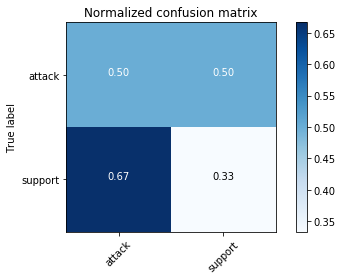

             precision    recall  f1-score   support

          0       0.37      0.21      0.26        34
          1       0.36      0.56      0.43        27

avg / total       0.36      0.36      0.34        61

Normalized confusion matrix
[[0.21 0.79]
 [0.44 0.56]]


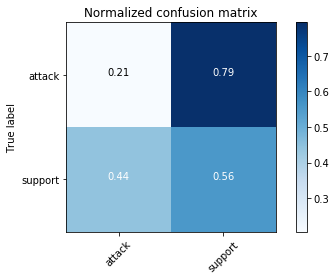

             precision    recall  f1-score   support

          0       0.61      0.41      0.49        34
          1       0.47      0.67      0.55        27

avg / total       0.55      0.52      0.52        61

Normalized confusion matrix
[[0.41 0.59]
 [0.33 0.67]]


             precision    recall  f1-score   support

          0       0.72      0.68      0.70        34
          1       0.61      0.65      0.63        26

avg / total       0.67      0.67      0.67        60

Normalized confusion matrix
[[0.68 0.32]
 [0.35 0.65]]


             precision    recall  f1-score   support

          0       0.70      0.56      0.62        34
          1       0.55      0.69      0.61        26

avg / total       0.64      0.62      0.62        60

Normalized confusion matrix
[[0.56 0.44]
 [0.31 0.69]]


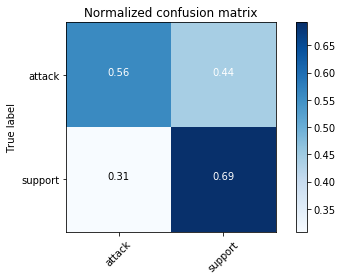

0.5322106909924202
0.5274748622336671
Average precision-recall score: 0.51


Text(0.5,1,'2-class Precision-Recall curve: AP=0.51')

In [336]:
acc = 0
f1 = 0
for train_index, test_index in skf.split(df_x, df_y):
    x_train, x_test = df_x[train_index], df_x[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]
    clf = NuSVC()
    clf.fit(x_train, y_train) 
    prediction = clf.predict(x_test)
    print(classification_report(y_test, prediction))
    f1 += f1_score(y_test, prediction, average='weighted')
    acc += accuracy_score(y_test, prediction)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, prediction)
    np.set_printoptions(precision=2)
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["attack", "support"], normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    
print (acc/8)
print(f1/8)

average_precision = average_precision_score(y_test, prediction)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, prediction)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
    

# Neural Network

In [303]:
acc = 0
f1 = 0
for train_index, test_index in skf.split(df_x, df_y):
    x_train, x_test = df_x[train_index], df_x[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]
    clf = MLPClassifier(activation = 'logistic', learning_rate='adaptive', solver='lbfgs')
    clf.fit(x_train, y_train) 
    prediction = clf.predict(x_test)
    print(classification_report(y_test, prediction))
    avg += f1_score(y_test, prediction, average='weighted')
    acc += accuracy_score(y_test, prediction)
print (acc/8)
print(f1/8)

average_precision = average_precision_score(y_test, prediction)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, prediction)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
    

             precision    recall  f1-score   support

          0       0.65      0.74      0.69        35
          1       0.59      0.48      0.53        27

avg / total       0.62      0.63      0.62        62

             precision    recall  f1-score   support

          0       0.63      0.85      0.72        34
          1       0.67      0.37      0.48        27

avg / total       0.65      0.64      0.61        61

             precision    recall  f1-score   support

          0       0.59      0.59      0.59        34
          1       0.48      0.48      0.48        27

avg / total       0.54      0.54      0.54        61

             precision    recall  f1-score   support

          0       0.51      0.65      0.57        34
          1       0.33      0.22      0.27        27

avg / total       0.43      0.46      0.44        61

             precision    recall  f1-score   support

          0       0.54      0.44      0.48        34
          1       0.42      0.52 

Text(0.5,1,'2-class Precision-Recall curve: AP=0.54')

# Nearest Neighbour

In [281]:
acc = 0
f1 = 0
for train_index, test_index in skf.split(df_x, df_y):
    x_train, x_test = df_x[train_index], df_x[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]
    clf = KNeighborsClassifier()
    clf.fit(x_train, y_train) 
    prediction = clf.predict(x_test)
    print(classification_report(y_test, prediction))
    f1 += f1_score(y_test, prediction, average='weighted')
    acc += accuracy_score(y_test, prediction)
print (acc/8)
print(f1/8)

             precision    recall  f1-score   support

          0       0.60      0.74      0.67        35
          1       0.53      0.37      0.43        27

avg / total       0.57      0.58      0.57        62

             precision    recall  f1-score   support

          0       0.63      0.71      0.67        34
          1       0.57      0.48      0.52        27

avg / total       0.60      0.61      0.60        61

             precision    recall  f1-score   support

          0       0.58      0.62      0.60        34
          1       0.48      0.44      0.46        27

avg / total       0.54      0.54      0.54        61

             precision    recall  f1-score   support

          0       0.46      0.53      0.49        34
          1       0.27      0.22      0.24        27

avg / total       0.38      0.39      0.38        61

             precision    recall  f1-score   support

          0       0.57      0.62      0.59        34
          1       0.46      0.41 

# Naive Bayesian

             precision    recall  f1-score   support

          0       0.57      0.97      0.72        35
          1       0.50      0.04      0.07        27

avg / total       0.54      0.56      0.43        62

             precision    recall  f1-score   support

          0       0.58      1.00      0.73        34
          1       1.00      0.07      0.14        27

avg / total       0.76      0.59      0.47        61

             precision    recall  f1-score   support

          0       0.56      0.91      0.70        34
          1       0.50      0.11      0.18        27

avg / total       0.54      0.56      0.47        61

             precision    recall  f1-score   support

          0       0.53      0.91      0.67        34
          1       0.00      0.00      0.00        27

avg / total       0.30      0.51      0.38        61

             precision    recall  f1-score   support

          0       0.57      0.94      0.71        34
          1       0.60      0.11 

Text(0.5,1,'2-class Precision-Recall curve: AP=0.47')

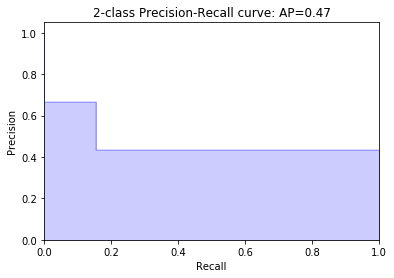

In [305]:
acc = 0
f1 = 0
for train_index, test_index in skf.split(df_x, df_y):
    x_train, x_test = df_x[train_index], df_x[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]
    clf = MultinomialNB()
    clf.fit(x_train, y_train) 
    prediction = clf.predict(x_test)
    print(classification_report(y_test, prediction))
    f1 += f1_score(y_test, prediction, average='weighted')
    acc += accuracy_score(y_test, prediction)
print (acc/8)
print(f1/8)

average_precision = average_precision_score(y_test, prediction)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, prediction)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
    